In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from packaging import version
from tensorflow.keras import layers, models, backend as k
import seaborn as sns
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error as MSE, confusion_matrix
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
import tensorflow_datasets as tfds
import re
import string
import time

In [ ]:
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

TensorFlow version:  2.15.0


In [ ]:
!tfds build --register_checksums --datasets=ag_news_subset

Traceback (most recent call last):
  File "/usr/local/bin/tfds", line 5, in <module>
    from tensorflow_datasets.scripts.cli.main import launch_cli
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/main.py", line 37, in <module>
    from tensorflow_datasets.scripts.cli import convert_format
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/convert_format.py", line 32, in <module>
    from tensorflow_datasets.scripts.cli import convert_format_utils
  File "/usr/local/lib/python3.10/dist-packages/tensorflow_datasets/scripts/cli/convert_format_utils.py", line 169, in <module>
    pipeline: beam.Pipeline | None = None,
  File "/usr/local/lib/python3.10/dist-packages/etils/epy/lazy_imports_utils.py", line 90, in __getattr__
    return getattr(self._module, name)
  File "/usr/lib/python3.10/functools.py", line 981, in __get__
    val = self.func(instance)
  File "/usr/local/lib/python3.10/dist-packages/etils/epy/lazy_imports_utils.

In [ ]:
# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)
text_only_dataset_all=dataset_all.map(lambda x, y: x)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/120000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.KIVHPK_1.0.0/ag_news_subset-train.tfrecord*...: …

Generating test examples...:   0%|          | 0/7600 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/ag_news_subset/incomplete.KIVHPK_1.0.0/ag_news_subset-test.tfrecord*...:  …

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# Check the dataframe
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [ ]:
# Check the categories
categories =dict(enumerate(info.features["label"].names))
print(f'Dictionary: ',categories)

Dictionary:  {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}


In [ ]:
# Review Class Balance
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [ ]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [ ]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [ ]:
# Text Vectorization and Vocabulary Adaptation
def text_vectorization_and_adapt(text_dataset, max_tokens=None, standardize_fn=None, output_sequence_length=None):
    text_vectorization = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        standardize=standardize_fn,
        output_sequence_length=output_sequence_length
    )
    text_vectorization.adapt(text_dataset)
    return text_vectorization

In [ ]:
def create_bidirectional_model_lstm64(vocab_size, output_sequence_length):
    k.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def create_bidirectional_model_dropout30(vocab_size, output_sequence_length):
    k.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(embedded)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def create_bidirectional_model_adam(vocab_size, output_sequence_length):
    k.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

def create_bidirectional_model_dense8(vocab_size, output_sequence_length):
    k.clear_session()
    inputs = tf.keras.Input(shape=(output_sequence_length,), dtype="int64")
    embedded = layers.Embedding(input_dim=vocab_size, output_dim=256, input_length=output_sequence_length)(inputs)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(8, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [ ]:
# Collecting results for the new experiments
new_experiments = [
    {"name": "edited_fixed_length_lstm64", "create_model_fn": create_bidirectional_model_lstm64, "vocab_size": 20000},
    {"name": "edited_fixed_length_dropout30", "create_model_fn": create_bidirectional_model_dropout30, "vocab_size": 20000},
    {"name": "edited_fixed_length_adam", "create_model_fn": create_bidirectional_model_adam, "vocab_size": 20000},
    {"name": "edited_fixed_length_dense8", "create_model_fn": create_bidirectional_model_dense8, "vocab_size": 20000}
]


In [ ]:
def train_and_evaluate_model_custom(vocab_size, text_vectorization, output_sequence_length, model_name, create_model_fn):
    # Print the name of the experiment
    print(f"Starting experiment: {model_name} with vocab size {vocab_size}")

    # Prepare the dataset
    def vectorize_text(text, label):
        text = text_vectorization(text)
        return text, label

    vectorized_dataset = dataset_all.map(vectorize_text)
    vectorized_dataset = vectorized_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    # Split the dataset
    dataset_size = len(list(vectorized_dataset))
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    train_dataset = vectorized_dataset.take(train_size).batch(32)
    val_dataset = vectorized_dataset.skip(train_size).take(val_size).batch(32)

    # Train the model
    model = create_model_fn(vocab_size, output_sequence_length)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(f"{model_name}.h5", save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
    start_time = time.time()
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=200, callbacks=callbacks)
    training_time = time.time() - start_time

    # Evaluate on validation dataset
    val_loss, val_accuracy = model.evaluate(val_dataset)

    # Load the best model and evaluate on validation dataset
    model = models.load_model(f"{model_name}.h5")
    test_loss, test_accuracy = model.evaluate(val_dataset)

    # Collect final train accuracy and loss
    train_acc = history.history['accuracy'][-1]
    train_loss = history.history['loss'][-1]

    return {
        'model_name': model_name,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'train_time': training_time,
        'val_acc': val_accuracy,
        'val_loss': val_loss,
        'test_acc': test_accuracy,
        'test_loss': test_loss,
        'history': history
    }

In [ ]:
all_results_new_experiments = []
for experiment in new_experiments:
    try:
        text_vectorization = text_vectorization_and_adapt(
            dataset_all.map(lambda text, label: text),
            max_tokens=experiment["vocab_size"],
            standardize_fn=custom_stopwords,
            output_sequence_length=100
        )
        results = train_and_evaluate_model_custom(experiment["vocab_size"], text_vectorization, 100, experiment["name"], experiment["create_model_fn"])
        all_results_new_experiments.append(results)
    except ValueError as e:
        print(f"Error with vocab_size {experiment['vocab_size']}: {e}")

Starting experiment: edited_fixed_length_lstm64 with vocab size 20000
Epoch 1/200
3190/3190 [==============================] - 46s 13ms/step - loss: 0.3917 - accuracy: 0.8676 - val_loss: 0.2877 - val_accuracy: 0.9022
Epoch 2/200
   7/3190 [..............................] - ETA: 29s - loss: 0.3800 - accuracy: 0.8795

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3190/3190 [==============================] - 32s 10ms/step - loss: 0.2617 - accuracy: 0.9161 - val_loss: 0.2814 - val_accuracy: 0.9049
Epoch 3/200
3190/3190 [==============================] - 31s 10ms/step - loss: 0.2245 - accuracy: 0.9295 - val_loss: 0.2804 - val_accuracy: 0.9063
Epoch 4/200
3190/3190 [==============================] - 31s 10ms/step - loss: 0.1938 - accuracy: 0.9390 - val_loss: 0.2993 - val_accuracy: 0.9050
Epoch 5/200
3190/3190 [==============================] - 31s 10ms/step - loss: 0.1685 - accuracy: 0.9479 - val_loss: 0.3036 - val_accuracy: 0.9064
Epoch 6/200
3190/3190 [==============================] - 31s 10ms/step - loss: 0.1450 - accuracy: 0.9566 - val_loss: 0.3324 - val_accuracy: 0.9033
Epoch 7/200
3190/3190 [==============================] - 31s 10ms/step - loss: 0.1229 - accuracy: 0.9640 - val_loss: 0.3638 - val_accuracy: 0.8998
Epoch 8/200
798/798 [==============================] - 5s 4ms/step - loss: 0.2804 - accuracy: 0.9063
Starting experiment: edited_f

In [ ]:
# Create a DataFrame to display the results
df_new_experiments = pd.DataFrame(all_results_new_experiments)

# Adjust display settings for better alignment
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Display the DataFrame
print(df_new_experiments)

                      model_name  train_acc  train_loss  train_time   val_acc  val_loss  test_acc  test_loss                                            history
0     edited_fixed_length_lstm64   0.969916    0.103696  265.904024  0.893926  0.408217  0.906348   0.280444  <keras.src.callbacks.History object at 0x7e10b...
1  edited_fixed_length_dropout30   0.957602    0.140507  202.176804  0.899843  0.342752  0.904937   0.282549  <keras.src.callbacks.History object at 0x7e100...
2       edited_fixed_length_adam   0.963489    0.112129  153.678845  0.895650  0.402561  0.908072   0.273373  <keras.src.callbacks.History object at 0x7e0f4...
3     edited_fixed_length_dense8   0.954105    0.155491  203.696553  0.904741  0.321569  0.908542   0.277640  <keras.src.callbacks.History object at 0x7e0f2...


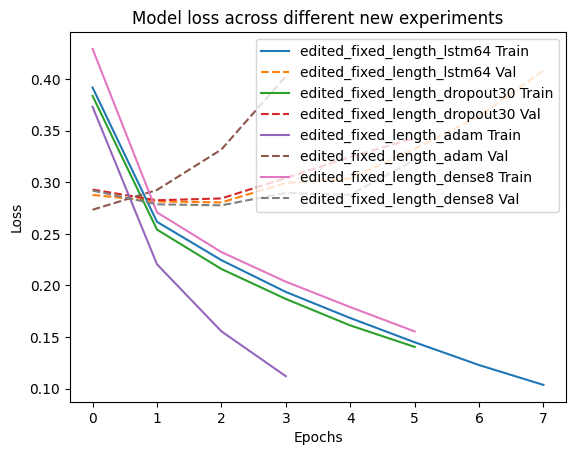

In [ ]:
# Plot loss vs epochs for different new experiments
for result in all_results_new_experiments:
    history = result['history']
    model_name = result['model_name']
    plt.plot(history.history['loss'], label=f'{model_name} Train')
    plt.plot(history.history['val_loss'], label=f'{model_name} Val', linestyle='--')

plt.title("Model loss across different new experiments")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Confusion Matrix with the Best Model

**edited_fixed_length_adam** has the **minimum training time 153 seconds** and **highest accuracy 0.908072**

In [ ]:
model_name = 'edited_fixed_length_adam'
vocab_size = 20000  # Use the vocab size from your experiment
output_sequence_length = 100  # Use the sequence length from your experiment

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Load the model
model = load_model(f'{model_name}.h5')

In [ ]:
# Prepare the text_vectorization layer
def text_vectorization_and_adapt(text_dataset, max_tokens=None, standardize_fn=None, output_sequence_length=None):
    text_vectorization = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        standardize=standardize_fn,
        output_sequence_length=output_sequence_length
    )
    text_vectorization.adapt(text_dataset)
    return text_vectorization

In [ ]:
# Prepare the test dataset
def vectorize_text(text, label):
    text = text_vectorization(text)
    return text, label

vectorized_dataset = dataset_all.map(vectorize_text)
dataset_size = len(list(vectorized_dataset))
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

test_dataset = vectorized_dataset.skip(train_size).take(val_size).batch(32)

In [ ]:
# Extract texts and labels from the test dataset
test_texts, test_labels = [], []
for text_batch, label_batch in test_dataset:
    test_texts.extend(text_batch.numpy())
    test_labels.extend(label_batch.numpy())

test_texts = np.array(test_texts)
test_labels = np.array(test_labels)

In [ ]:
# Make predictions on the test dataset
predictions = model.predict(test_texts)
predicted_labels = np.argmax(predictions, axis=1)

798/798 [==============================] - 4s 4ms/step


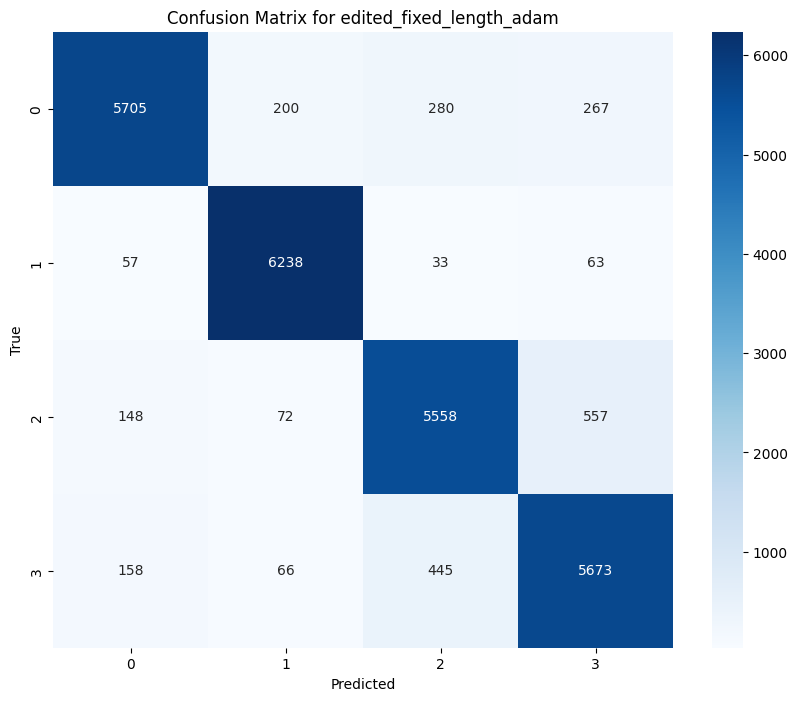

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      6452
           1       0.95      0.98      0.96      6391
           2       0.88      0.88      0.88      6335
           3       0.86      0.89      0.88      6342

    accuracy                           0.91     25520
   macro avg       0.91      0.91      0.91     25520
weighted avg       0.91      0.91      0.91     25520



In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

# Print classification report
print(classification_report(test_labels, predicted_labels))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/458_M6_A3_lstm_bi_edited_fixed_20k.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/458_M6_A3_lstm_bi_edited_fixed_20k.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/pyt